In [1]:
import numpy as np
import uproot
# import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import json
import configparser
from multihist import Hist1d, Histdd
import numba

In [2]:
import sys
#Change this to whatever path you're using
sys.path.append('/home/jyangqi/sandaq/')
import sandawpy

In [14]:
hits_root = uproot.open('/home/jyangqi/TestSandaq/test_output/lowtrigger.root')
hit_wfs = hits_root['hits']['waveform'].array()
hit_starts = hits_root['hits']['start_time'].array()
hit_ends = hits_root['hits']['end_time'].array()
hit_channels = hits_root['hits']['channel'].array()

In [3]:
config_file = '/home/jyangqi/TestSandaq/sandaw/config/config.ini'
pk_processed = '/home/jyangqi/TestSandaq/test_output/peaks_bkg_first_test_s1s2_lowtrigger_first.bin'
evt_processed = '/home/jyangqi/TestSandaq/test_output/events_bkg_first_test_s1s2_lowtrigger_first.bin'

In [4]:
loader = sandawpy.Loader(config_file)
peaks = loader.GetData(pk_processed, 'peaks')
events = loader.GetData(evt_processed, 'events')

# Uncomment this if you want to only get a few columns
# peaks_few_columns = loader.GetData(pk_processed, 'peaks', cols = ['area'])

In [8]:
waveform_file = '/home/jyangqi/TestSandaq/test_output/waveforms_bkg_first_test_s1s2_lowtrigger_first.bin'

In [9]:
waveform_all = np.fromfile(waveform_file, dtype = np.float32)

In [10]:
indices = np.pad(np.repeat(np.cumsum(peaks['n_samples']),2)[:-1], (1,0)).reshape(len(peaks),2)

In [12]:
s2s = peaks[peaks['type']==2]
s1s = peaks[peaks['type']==1]
s2_locations = np.where(peaks['type']==2)[0]

[11022672, 11022664, 11022652, 11022632, ..., 11022684, 11023208, 11023316]
[125153318400, 125153318420, 125153318444, ..., 125153319068, 125153319028]
199 199


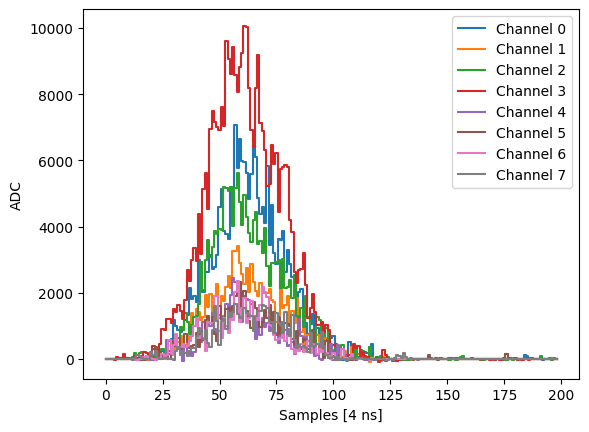

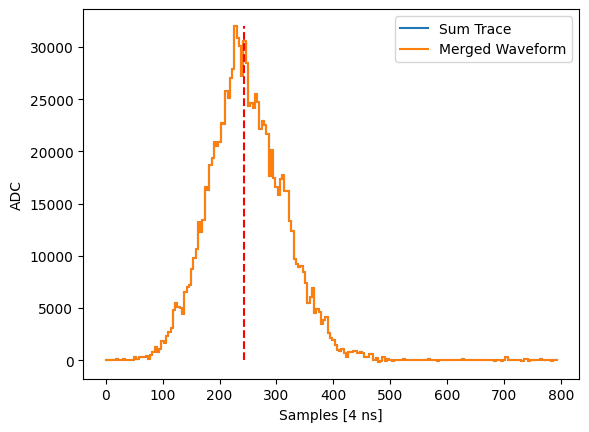

In [32]:
#Making sure that the hits match up with the peaks

GainConvert = 6095.248943620215

for i in range(1):
    prev_hit_sel = (hit_starts>=s2s[i-1]['start_time'])&(hit_starts<=s2s[i-1]['end_time'])
    hit_selection = (hit_starts>=s2s[i]['start_time'])&(hit_starts<=s2s[i]['end_time'])
    s = 0
    window_len = int((s2s[i]['end_time']-s2s[i]['start_time'])/4)
    hits_in_s2 = hit_wfs[hit_selection]
    hits_in_s2_start = hit_starts[hit_selection]
    prev_hits_in_s2_start = hit_starts[prev_hit_sel]
    print(hits_in_s2_start)
    print(prev_hits_in_s2_start)
    print(window_len, len(waveform_all[indices[s2_locations[i]][0]:indices[s2_locations[i]][1]]))

    hits_in_s2_end = hit_ends[hit_selection]
    channels_in_s2 = hit_channels[hit_selection]
    shifts = np.array((hits_in_s2_start-min(hits_in_s2_start))/4).astype('int')
    trace = np.zeros((8, window_len))

    for j in range(len(channels_in_s2)):
        right_edge = int(len(hits_in_s2[j])+shifts[j])
        trace[channels_in_s2[j]][shifts[j]:right_edge] += np.array(hits_in_s2[j])
    for k in range(8):
        plt.plot(trace[k], label = f'Channel {k}', drawstyle = 'steps-mid')
    plt.legend()
    plt.xlabel('Samples [4 ns]')
    plt.ylabel('ADC')
    # plt.savefig('ex_s2_hits')
    plt.show()

    plt.plot(np.arange(len(np.sum(trace, axis = 0)))*4,np.sum(trace, axis = 0), drawstyle = 'steps-mid', label = 'Sum Trace')
    mwf = waveform_all[indices[s2_locations[i]][0]:indices[s2_locations[i]][1]]
    plt.plot(np.arange(len(mwf))*s2s[i]['dt'],(1e6/GainConvert)*4*mwf/s2s[i]['dt'], label = 'Merged Waveform', drawstyle = 'steps-mid')
    height = np.max((1e6/GainConvert)*4*mwf/s2s[i]['dt'])
    plt.vlines(s2s[i]['center_time']-s2s[i]['start_time'],0, height, linestyle = 'dashed', color = 'r')
    plt.legend()
    plt.xlabel('Samples [4 ns]')
    plt.ylabel('ADC')
    # plt.savefig('ex_s2_merged')
    # plt.title(len(waveform_all[indices[s2_locations[i]][0]:indices[s2_locations[i]][1]]))
    plt.show()

# Scratch

In [33]:
l, r = events['window_start_time'], events['window_end_time']

Drift Time: 4845.535892486572
S1 Areas: [1243.8822]
S2 Areas: [6752.9644]


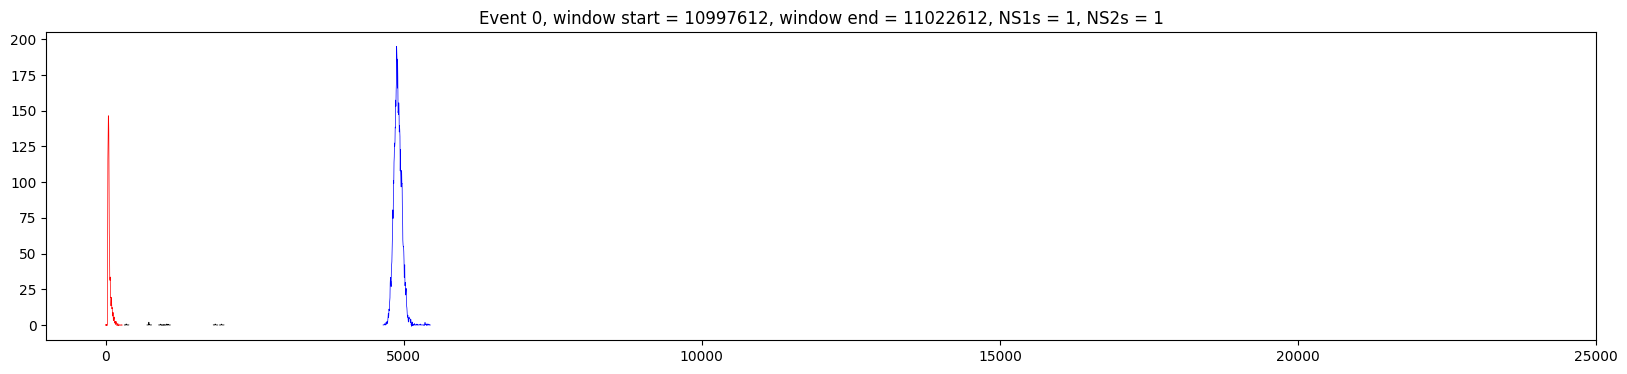

Drift Time: 5877.072891235352
S1 Areas: [2413.5244]
S2 Areas: [ 401.21375 2792.9097  5005.309  ]


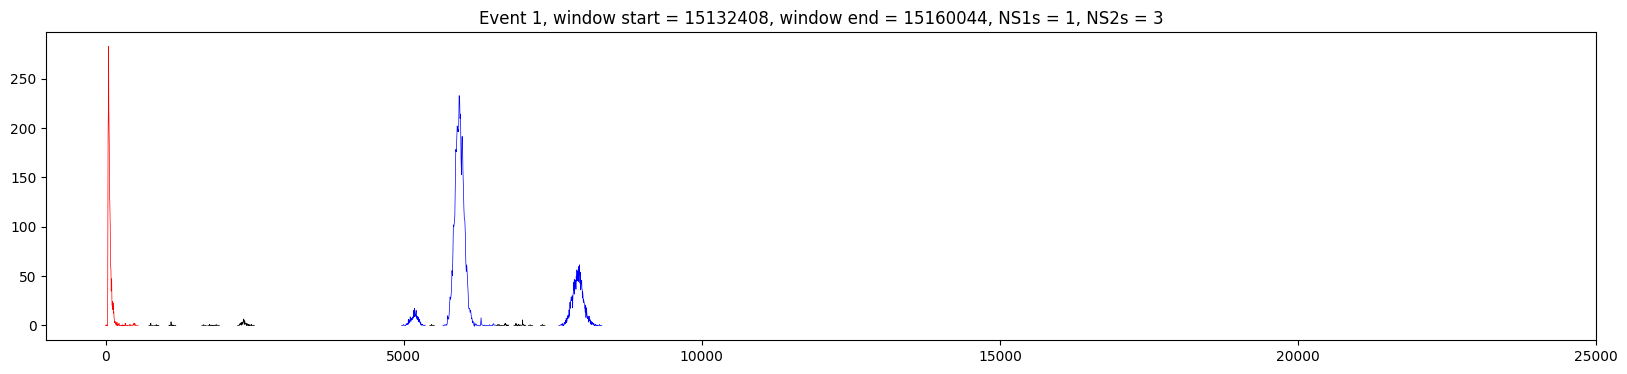

In [36]:
#Construct events from peaks to see if the info is correct
colors = ['k', 'r', 'b']
for i in range(2):
    peaks_in_window = (peaks['start_time']>=l[i])&(peaks['start_time']<=r[i])
    p = peaks[peaks_in_window]
    s1p, s2p = p[p['type']==1], p[p['type']==2]
    ind = indices[peaks_in_window]
    min_start = np.min(p['start_time'])
    plt.figure(figsize = (20,4))
    for j in range(np.sum(peaks_in_window)):
        plt.plot(np.arange(p['n_samples'][j])*p['dt'][j] + p['start_time'][j]-min_start,
                 waveform_all[ind[j][0]:ind[j][1]], linewidth = 0.5, color = colors[p['type'][j]])
    plt.xlim(-1000,25000)
    plt.title(f"Event {i}, window start = {l[i]}, window end = {r[i]}, NS1s = {np.sum(p['type']==1)}, NS2s = {np.sum(p['type']==2)}")
    argsort_s1_areas = np.argsort(s1p['area'])
    argsort_s2_areas = np.argsort(s2p['area'])
    
    main_s1 = s1p[np.argmax(s1p['area'])]
    main_s1_wf_ind = ind[np.argmax(s1p['area'])]
    main_s2 = s2p[np.argmax(s2p['area'])]
    main_s2_wf_ind = ind[np.argmax(s2p['area'])]

    print(f"Drift Time: {main_s2['center_time']-main_s1['center_time']}")
    print(f"S1 Areas: {np.sort(s1p['area'])}")
    print(f"S2 Areas: {np.sort(s2p['area'])}")
    # plt.vlines(main_s1['max_time']-min_start, 0, np.max(waveform_all[main_s1_wf_ind[0]:main_s1_wf_ind[1]]))
    # plt.vlines(main_s2['max_time']-min_start, 0, np.max(waveform_all[main_s2_wf_ind[0]:main_s2_wf_ind[1]]))
    plt.show()

In [30]:
print(events['drift_time'][:10])
print(events['n_s1'][:10])
print(events['n_s2'][:10])
print(events['main_s1_area'][:10])
print(events['main_s2_area'][:10])
print(events['alt_s1_area'][:10])
print(events['alt_s2_area'][:10])

[ 4845.536   5877.0728 16830.98   12871.251  11050.909   3508.9966
  9212.897  10695.433  15968.154   6149.2354]
[1 1 1 1 1 1 1 1 1 1]
[1 3 1 3 2 2 2 2 1 3]
[1243.8822 2413.5244 3969.574  2366.3577 1835.2976 2605.7793 2289.5947
 2609.5527 4931.5825 1980.1027]
[ 6752.9644  5005.309  13731.68    4061.5269  3777.0564  5338.942
  4470.2197  4050.7131  5261.943   4871.824 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[   0.     2792.9097    0.     2576.474  3366.1113 4563.6157 2661.1306
  393.6983    0.      555.6184]
